## T51 Task 1

#### Exploring the data

In [635]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv",index_col='City')
df.index.names = ['State'] # rename 
df.head()



,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


In [636]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 4


We then need to summarise the statistical properties of the columns:

In [637]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


We also need to determine if we have any missing values, and which features these occur for:

In [638]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


It is often useful to determine the type of each variable. We see that we are working predominantly with continuous variables:

In [639]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


To visualise the distribution of the observations for each feature, we plot a histogram using Pandas's ```.hist()``` function:
* Documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

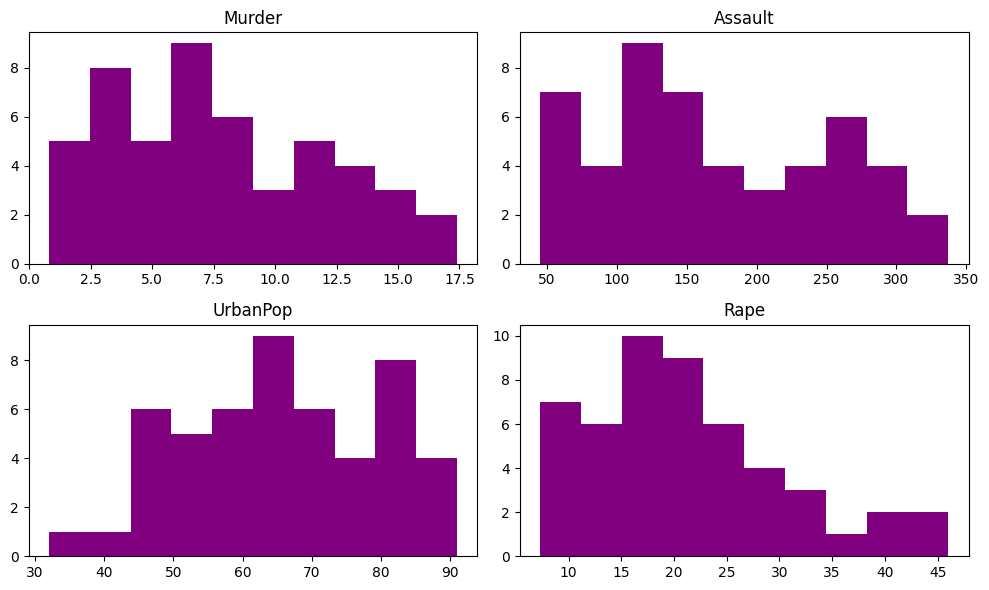

In [640]:
# Plot histograms
histograms = df.hist(color='purple', grid=False, figsize=(10, 6)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


We can compile the tabular information we have so far into a single dataframe:

In [641]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


At first glance, the GDP per capita variable stands out as having a mean and standard deviation which is dramatically higher than the other variables. This makes sense as most of the other variables are percentages or ratios per 1000 people while GDP per Capita is in US$. This indicates that scaling the data will be useful to keep the GDP per capita from impacting the analysis disproportionately.

#### Missing values - KNN imputation

There are no missing values and therefore we can proceed without requiring KNN imputation. 

#### Correlation Analysis

Pandas offers a highly useful function, ``corr``, which allows us to compute correlations between the different columns. The standard correlation coefficient is the Pearson coefficient. It returns a matrix of values. It is often useful to visualise these as a plot. Both Pandas and Seaborn have functions for plotting correlation heatmaps, but Seaborn's offers more adjustabilty. We demonstrate the use of Seaborn's heatmap, using a mask to remove the top triangular half of correlations, as these are repeats.

In [664]:
states = df.index
corr_df = df.corr()
labels =corr_df.columns

print(corr_df)

          Murder  Assault  UrbanPop  Rape
Murder     1.000    0.802     0.070 0.564
Assault    0.802    1.000     0.259 0.665
UrbanPop   0.070    0.259     1.000 0.411
Rape       0.564    0.665     0.411 1.000


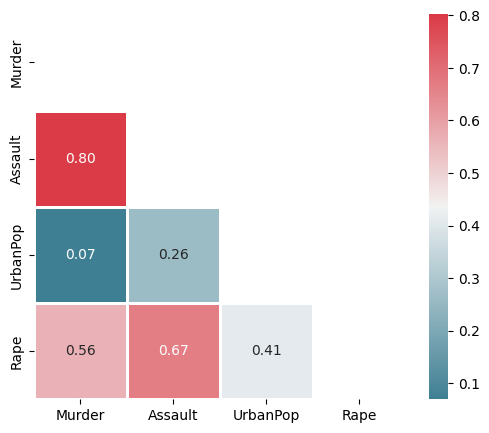

In [665]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(6, 5))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)

In the plot, there is a linear correlation between strongly correlated variables: those coloured in either dark red or dark blue. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other, while negatively correlated variables are blue: a decrease in one means an increase in the other.

From the correlation plot, it is evident that murder has a strong positive correlation with assault. Assault is similarly correlated with rape but less strongly than with murder. Urban population is negatively correlated with all forms of violent crime; that is, there is an increase in prevalence of violent crime where there is a decreased percentage of the population in urban areas falls. This suggests that violent crime is most prevalent per head of population in US states where the percentage of population in urban areas is lowest. This is, perhaps, counter-intuitive, but this might simply indicate that New York (for example) is a much more populous state.

 Overall, there are many variables that have strong negative and positive correlations with each other. This makes the data a good candidate for PCA. PCA will be able to reduce variables which encode similar types of differences between countries in a way that requires fewer dimensions.


## PCA

Principal Components Analysis (PCA) is a method for finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these. 



In [666]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [667]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


#### PCA interpretation

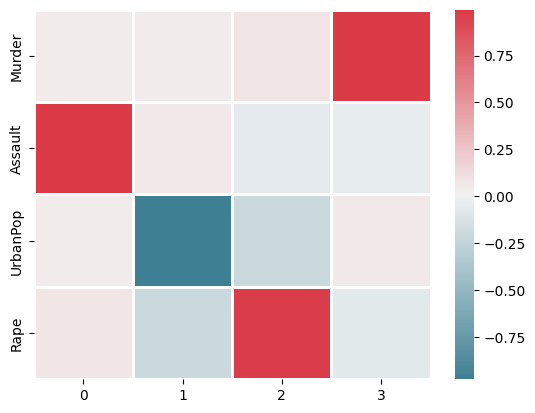

In [668]:
components = pd.DataFrame(pca.components_, columns=df.columns).transpose()
ax = sns.heatmap(components,cmap=colormap,linewidth=1)
plt.show()

In [669]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


The first component explains 96.7% of the variance; the second component explains a further 2.8% and the third/fourth components explain <0.6% of the variance.

In [670]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_ratio_)}")

Cumulative Proportion: [0.97 0.99 1.   1.  ]


#### Biplot

In [834]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex, ys * scaley, s=20)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley), fontsize = 9)

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

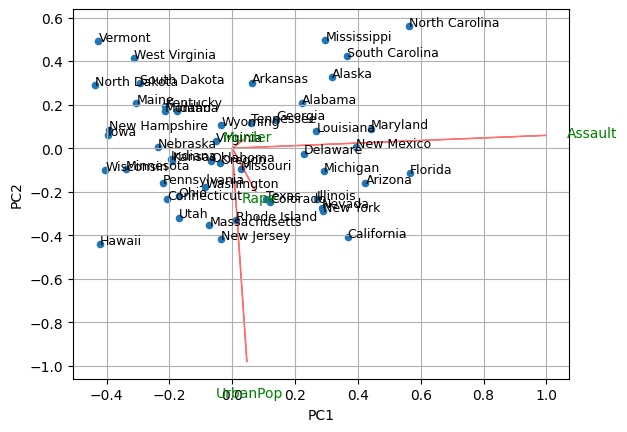

In [835]:
biplot(X_trans[:,0:2], np.transpose(pca.components_[0:2, :]), list(labels), list(states))
plt.show()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From this biplot, we see that GDP and the mortality rates for males and females are the most important featuresas the arrows to each of these dominate the biplot.

This information can also be quantified as follows:

In [836]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


We see that the unmber of assaults per 100,000 population has by far the highest importance in the first principal component, while the urban population is similarly strongly dominated by the proportion of the population living in urban areas. These observations agree with those deduced from the biplot. If we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. 

It is likely that because of this, these features 'swamp' the others, which results in them being ignored, and therefore we need to standardise data to get meaningful analysis for this task.

### Standardised data

We standardise the data so that some features do not swamp the others.

In [837]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


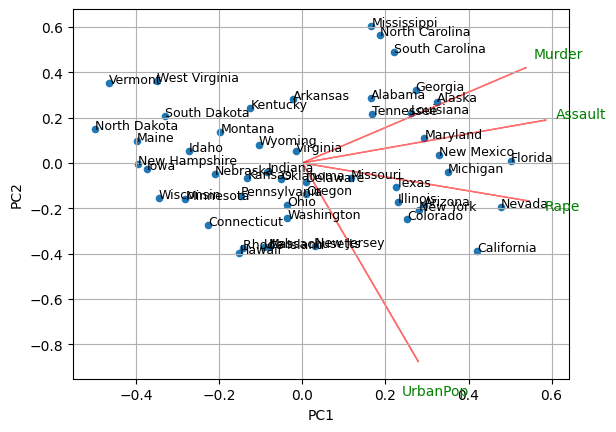

In [838]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the the different features cluster together in groups.

In [839]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance.

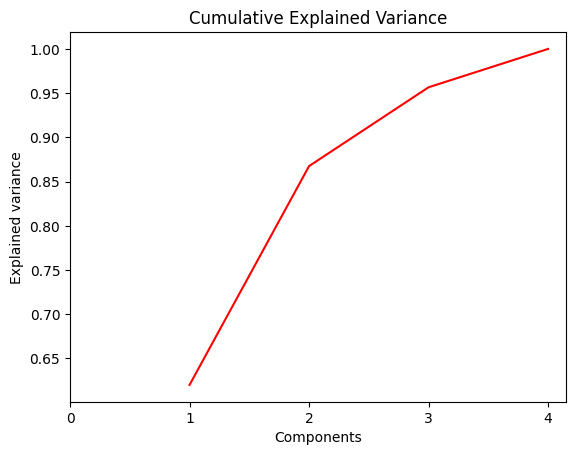

In [840]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")
start, end = ax.get_xlim()
plt.xticks(np.arange(0, round(end,0)+1.1, 1.0))
plt.show()

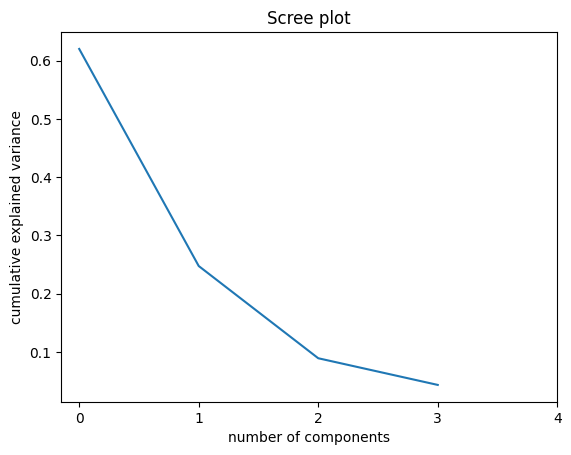

In [841]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
start, end = ax.get_xlim()
plt.xticks(np.arange(0, round(end,0)+1.1, 1.0))
plt.show()

The first 5 principal components together explain around 90% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction. We began with 19 variables and now we have 5 variables explaining most of the variability. 


In [842]:
pca_df = pd.DataFrame(X_std_trans[:,0:5], index = df.index)
pca_df.head()

,0,1,2,3
State,,,,
Alabama,0.986,1.133,-0.444,0.156
Alaska,1.950,1.073,2.040,-0.439
Arizona,1.763,-0.746,0.055,-0.835
Arkansas,-0.141,1.120,0.115,-0.183
California,2.524,-1.543,0.599,-0.342


## Hierarchical clustering


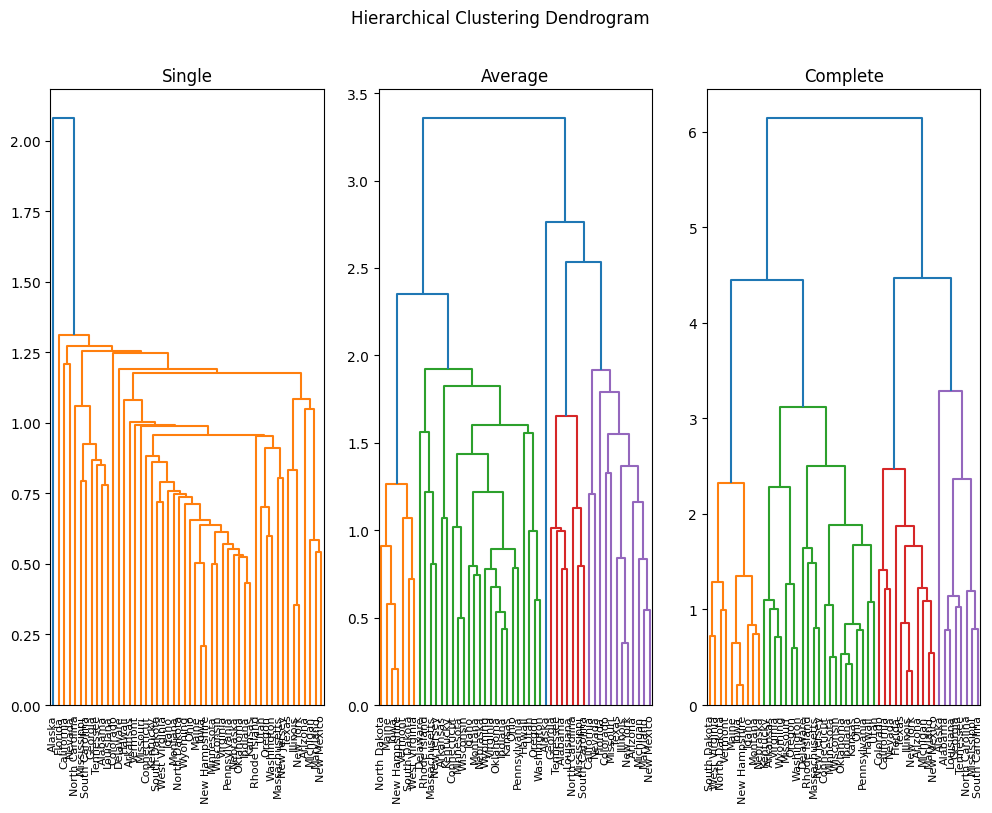

In [843]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

The complete linkage dendrogram gives the most meaningful interpretation, so we will continue with the 'complete linkage' model:

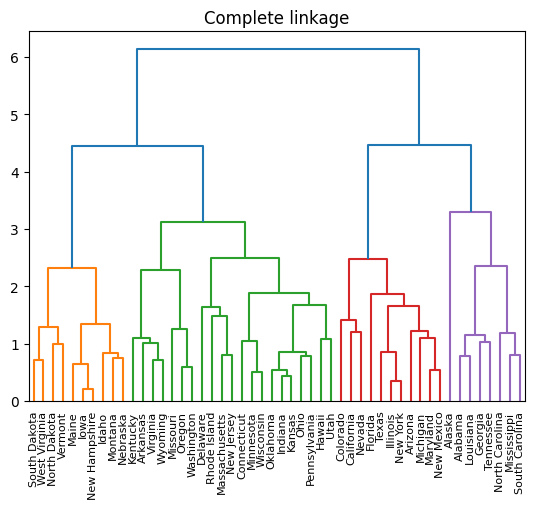

In [844]:
from numpy import arange
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

From the dendrogram we see that the biggest differences are between the orange/green states on the left, and the red/purple states on the right. Cutting through the dendrogram horizontally just below the top of the longest line (Alaska), we see that there is natural clustering of:
- the orange states (Dakotas, Vermont, Maine, New Hampshire, Montana, Nebraska etc)
- two separate groups of green states (group 1: Kentucky, Arkansas, Virginia, Wyoming, Missourie, Oregon, Washington State, and group 2: north-eastern US, Oklahoma, Indiana, Kansas, Pennsylvania, Utah and Ohio)
- the red states (Colorado, Texas, New York, Arizona, New Mexico and Maryland)
- Alaska
- the other purple states (the Carolinas, Alabama, Louisiana, Georgia, Tennessee and Mississippi)

### K-means clustering

For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 3. A visualisation of the clusters is shown in the figure below.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


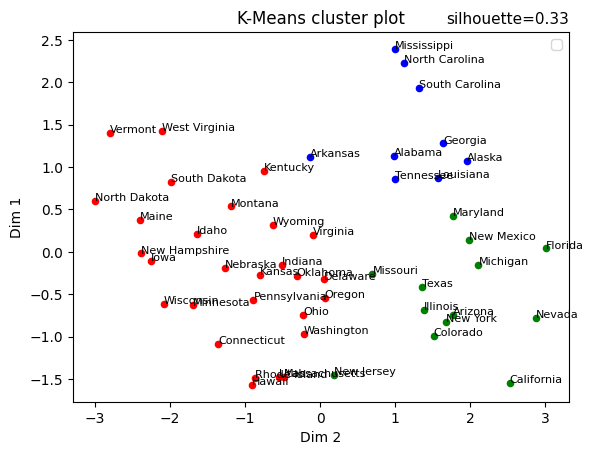

In [845]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', n_init = 'auto', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i], y[cluster_labels == i], c = colours[i], s = 20) 

score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 11}, pad=-14)
    
for i in range(0,len(x)):
    txt = states[i]
    ax.annotate(txt, (x[i], y[i]), fontsize=8)
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

The silhouette score is 0.33, which means that there is some clustering but it is not particularly strong. Looking at the data, there appears to be a clustering around states with high urban population and high violent crime (green), states with low urban population and high violent crime (red), and low urban population and low violent crime (blue). We can examine this further by tabulating as below.

In [846]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(states)[group0_indices]
group1 = np.array(states)[group1_indices]
group2 = np.array(states)[group2_indices]

In [847]:
df.loc[group1]

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arkansas,8.800,190,50,19.500
Georgia,17.400,211,60,25.800
Louisiana,15.400,249,66,22.200
Mississippi,16.100,259,44,17.100
North Carolina,13.000,337,45,16.100
South Carolina,14.400,279,48,22.500
Tennessee,13.200,188,59,26.900


In [848]:
df.loc[group2]

,Murder,Assault,UrbanPop,Rape
State,,,,
Arizona,8.100,294,80,31.000
California,9.000,276,91,40.600
Colorado,7.900,204,78,38.700
Florida,15.400,335,80,31.900
Illinois,10.400,249,83,24.000
Maryland,11.300,300,67,27.800
Michigan,12.100,255,74,35.100
Missouri,9.000,178,70,28.200
Nevada,12.200,252,81,46.000
